Detection Model

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!pip install -U -r yolov5/requirements.txt  

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/yolov5
%cat /content/yolov5/models/yolov5l.yaml

/content/yolov5
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1

## 2. Import main libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import random
import cv2
import numpy as np
import torch
from IPython.display import Image  
from sklearn.model_selection import train_test_split

print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

AttributeError: ignored

In [ ]:
data = pd.read_csv("/content/detection_tesla.csv", index_col="num")
data = data.dropna().reset_index(drop=True)

In [ ]:
DATASETS_PATH = "/content/datasets/"
if os.path.exists(DATASETS_PATH):
  shutil.rmtree(DATASETS_PATH)

os.mkdir(DATASETS_PATH)

for idx, sample in data.iterrows():
  download_url = "https://public.roboflow.com/ds/"+sample["dataset_code"]+"?key="+sample["dataset_password"]
  labeller_name = sample["labeller"].split(" ")[0]
  !curl -L "$download_url" > roboflow.zip; unzip roboflow.zip -d "/content/datasets/$labeller_name" > /dev/null; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   1014      0 --:--:-- --:--:-- --:--:--  1013
100 33.0M  100 33.0M    0     0  25.9M      0  0:00:01  0:00:01 --:--:-- 25.9M


Create a dataframe with all images

In [ ]:
dataset = pd.DataFrame(columns=["labeller", "neighbourhood", "image", "label"]) 
for idx, sample in data.iterrows():
  labeller_name = sample["labeller"].split(" ")[0]
  for folder in os.listdir("/content/datasets/"+labeller_name):
    if folder in ["train","test","valid"]:
      sub_df = pd.DataFrame(columns=["labeller", "neighbourhood", "image", "label"]) 

      base_path = "/content/datasets/"+labeller_name+"/"+folder
      images = [base_path+"/images/"+image for image in os.listdir(base_path+"/images")]
      labels = [base_path+"/labels/"+label for label in os.listdir(base_path+"/labels")]
      labellers = [sample["labeller"] for val in images]
      hoods = [sample["neighbourhood"] for val in images]

      images.sort()
      labels.sort()

      sub_df["labeller"] = labellers
      sub_df["neighbourhood"] = hoods
      sub_df["image"] = images
      sub_df["label"] = labels

      dataset = pd.concat([dataset, sub_df], sort=False)

dataset = dataset.reset_index(drop=True)
dataset

,labeller,neighbourhood,image,label
0,People,Tesla,/content/datasets/People/valid/images/273271-1...,/content/datasets/People/valid/labels/273271-1...
1,People,Tesla,/content/datasets/People/valid/images/273271-1...,/content/datasets/People/valid/labels/273271-1...
2,People,Tesla,/content/datasets/People/valid/images/273271-1...,/content/datasets/People/valid/labels/273271-1...
3,People,Tesla,/content/datasets/People/valid/images/273271-1...,/content/datasets/People/valid/labels/273271-1...
4,People,Tesla,/content/datasets/People/valid/images/273271-1...,/content/datasets/People/valid/labels/273271-1...
...,...,...,...,...
505,People,Tesla,/content/datasets/People/test/images/273275-52...,/content/datasets/People/test/labels/273275-52...
506,People,Tesla,/content/datasets/People/test/images/273275-a3...,/content/datasets/People/test/labels/273275-a3...
507,People,Tesla,/content/datasets/People/test/images/273278-7e...,/content/datasets/People/test/labels/273278-7e...
508,People,Tesla,/content/datasets/People/test/images/273278-7e...,/content/datasets/People/test/labels/273278-7e...


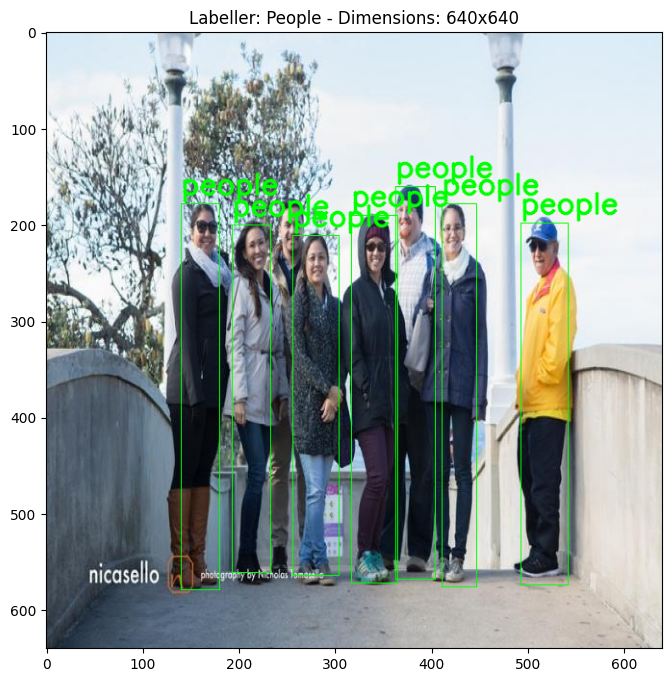

In [ ]:
def show_image_txt_label(dataset, classes, index): 
  image = cv2.imread(dataset.at[index,"image"])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  height, width, _ = image.shape

  with open(dataset.at[index,"label"]) as txt:
    lines = txt.readlines()
    for line in lines:
      id = line.split(" ")[0]
      if id!= "\n" and len(id) > 0:
        id = int(id)
        try:
          label = classes[id]
        
          x=float(line.split(" ")[1])
          y=float(line.split(" ")[2])
          w=float(line.split(" ")[3])
          h=float(line.split(" ")[4])

          # Convert Yolo format to rectangular coordinates
          l = int((x - w / 2) * width)
          r = int((x + w / 2) * width)
          t = int((y - h / 2) * height)
          b = int((y + h / 2) * height)

          if l < 0:
            l = 0
          if r > width - 1:
            r = width - 1
          if t < 0:
            t = 0
          if b > height - 1:
            b = height - 1

          font = cv2.FONT_HERSHEY_SIMPLEX
          # Put text
          cv2.putText(image, label,(l,t-10),font,1,(0,255,0),2,cv2.LINE_AA)
          # Draw bounding box
          cv2.rectangle(image, (l, t), (r, b), (0,255,0), 1)
        except:
          print("Error." + dataset.at[index,"labeller"] + " labelled with more than one class")
      else: 
        continue
  plt.rcParams["figure.figsize"] = (8,8) 
  plt.title("Labeller: " + dataset.at[index,"labeller"] + " - Dimensions: "+str(width)+"x"+str(height))
  plt.imshow(image)

classes = {0:"people"}
num = random.randint(0,len(dataset)-1)
show_image_txt_label(dataset, classes, num)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


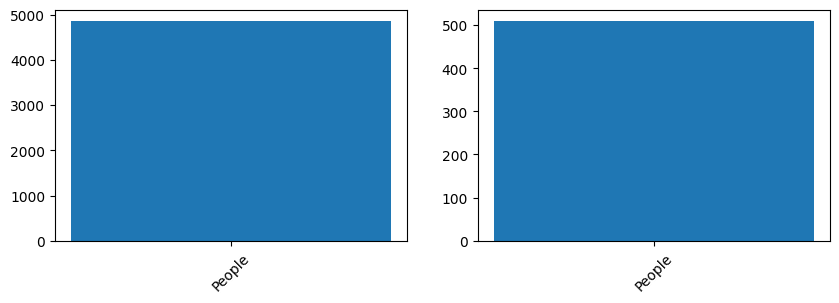

In [ ]:
def find_labeller_distribution_txt(dataset):
  instances = {}
  images = {}
  for idx, sample in dataset.iterrows():
    if sample["labeller"] not in images.keys(): 
      images[sample["labeller"]] = 1
    else:
      images[sample["labeller"]] += 1


    with open(sample["label"]) as txt:
      lines = txt.readlines()
      for line in lines:
        if sample["labeller"] not in instances.keys(): 
          instances[sample["labeller"]] = 1
        else:
          instances[sample["labeller"]] += 1
  
  fig, ax = plt.subplots(1,2, figsize=(10,3))
  ax[0].bar(instances.keys(),instances.values())
  ax[0].set_xticklabels(labels=instances.keys(), rotation=45)
  ax[1].bar(images.keys(),images.values())
  ax[1].set_xticklabels(labels=images.keys(), rotation=45);

find_labeller_distribution_txt(dataset)

In [ ]:
NEW_DATASET_PATH = "/content/people_dataset"

if os.path.exists(NEW_DATASET_PATH):
  shutil.rmtree(NEW_DATASET_PATH)

os.mkdir(NEW_DATASET_PATH)

def move_files(subset, subset_name): 
  os.mkdir(NEW_DATASET_PATH+"/"+subset_name)
  os.mkdir(NEW_DATASET_PATH+"/"+subset_name+"/images")
  os.mkdir(NEW_DATASET_PATH+"/"+subset_name+"/labels")
  
  for idx, sample in subset.iterrows():

    file_name = sample["image"].split("/")[6]
    target_file = NEW_DATASET_PATH+"/"+subset_name+"/images/"+file_name
    shutil.copy(sample["image"], target_file)


    file_name = sample["label"].split("/")[6]
    target_file = NEW_DATASET_PATH+"/"+subset_name+"/labels/"+file_name
    shutil.copy(sample["label"], target_file)

def train_validate_test_split(df, train_percent=.7, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

print(len(dataset))
train_set, validation_set, test_set = train_validate_test_split(dataset, 0.7, 0.2)

print("Train set size: ", len(train_set), "Validation set size: ", len(validation_set), "Test set:", len(test_set))

move_files(train_set, "train")
move_files(test_set, "test")
move_files(validation_set, "valid")

510
Train set size:  357 Validation set size:  102 Test set: 51


In [ ]:

num_classes = 1


from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# change the location of the training and validation subsets. The rest
# of the file remains equal. 

%%writetemplate /content/yolov5/data.yaml

train: /content/people_dataset/train/images
val: /content/people_dataset/valid/images
test: /content/people_dataset/test/images

nc: 1
names: ['people']

In [ ]:
%cat data.yaml


train: /content/people_dataset/train/images
val: /content/people_dataset/valid/images
test: /content/people_dataset/test/images

nc: 1
names: ['people']


In [ ]:
# Change the number of classes defined in the yolo v5 architectures. the rest remains the same. 
%%writetemplate /content/yolov5/models/custom_yolov5l.yaml

# Parameters
nc: {num_classes}  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
%cat models/custom_yolov5l.yaml


# Parameters
nc: 1  # number of classes
depth_multiple: 1.0  # model depth multiple
width_multiple: 1.0  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, Fals

## 5. Train the model

Training with Yolov5 can be done by using a script named `train.py`, which will require the following parameters:

* **img:** input image size (width == height)
* **batch:** batch size
* **epochs:** number of training epochs. 
* **data:** path to our yaml file
* **cfg:** model configuration
* **weights:** custom path to save the best weights. 
* **name:** output file with metric results
* **nosave:** boolean that specifies to only save the final checkpoint
* **cache:** boolean that specifies to cache images for faster training

In [ ]:
# Since we exported the dataset for Yolo v5, we don't need to resize the images.
# We will train the model for 5 epoch with batch size of 80, however, you can 
# change these parameters to get a better performance
# train.py uses the subsets information from data.yaml. 

%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 30 --data './data.yaml' --cfg './models/custom_yolov5l.yaml' --weights ''

/content/yolov5
train: weights=, cfg=./models/custom_yolov5l.yaml, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-4-g7398d2d Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv

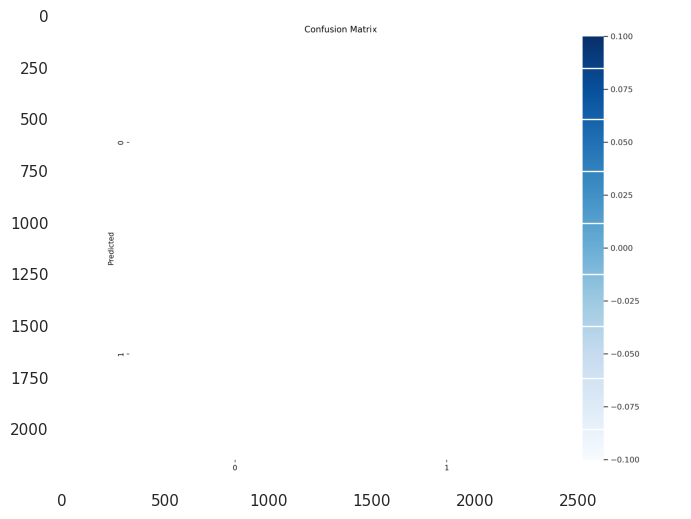

In [ ]:
from yolov5.utils.metrics import ConfusionMatrix
import cv2

confusion_matrix = ConfusionMatrix(nc=1)

confusion_matrix.plot()

img = cv2.imread("/content/yolov5/confusion_matrix.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [ ]:
# final weights will be stored by default at /content/yolov5/runs/train/exp2/weights/best.pt
%cd /content/yolov5/

!python detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --img 64 --conf 0.1 --source /content/people_dataset/test/images

/content/yolov5
detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/people_dataset/test/images, data=data/coco128.yaml, imgsz=[64, 64], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-4-g7398d2d Python-3.7.15 torch-1.13.0+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
custom_YOLOv5l summary: 267 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/51 /content/people_dataset/test/images/273271-1050b000e40d8e93_jpg.rf.e060bee6241a263aff19b09695a42a83.jpg: 64x64 3 peoples, 23.1ms
image 2/51 /content/people_dataset/test/images/273271-137e00009da93233_jpg.rf.1fe2e2f7ecc4a93f4c7b30d19fa27934.jpg: 64x64 3 peoples, 21.5ms
image 3/51 /

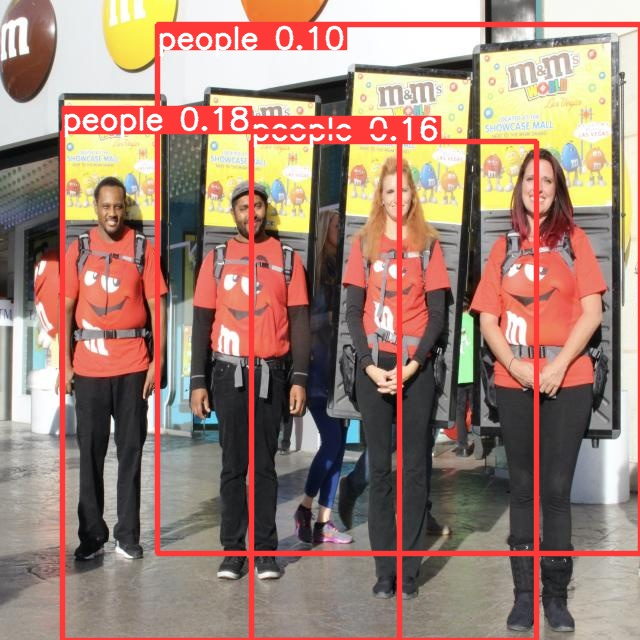

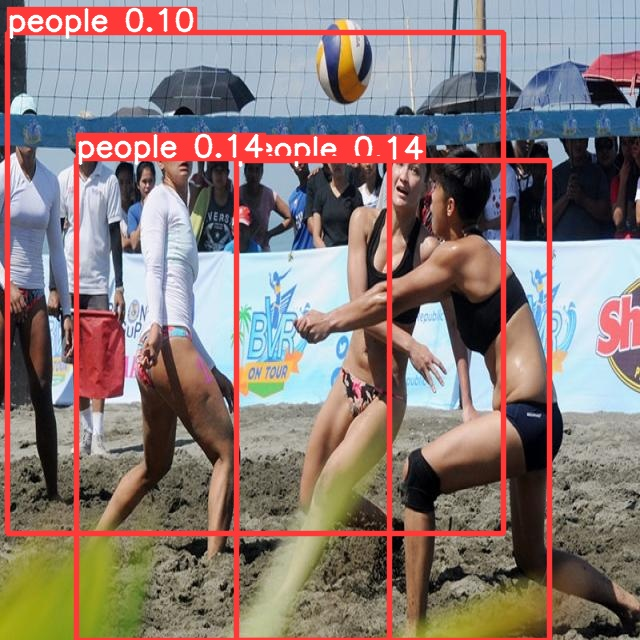

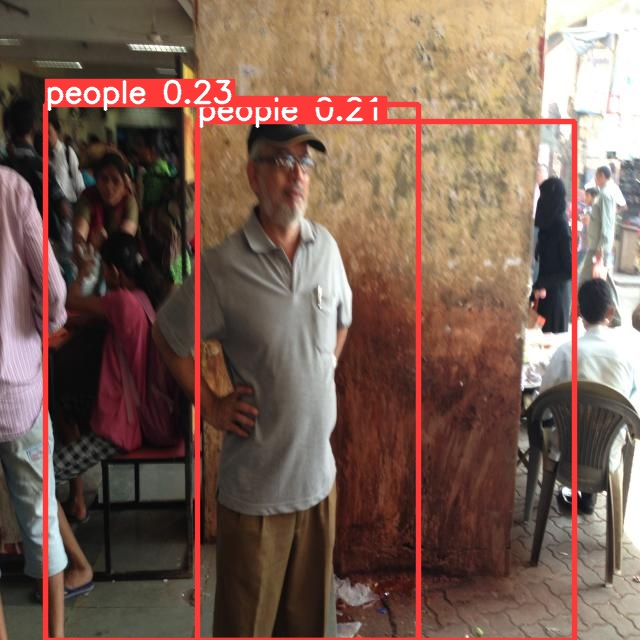

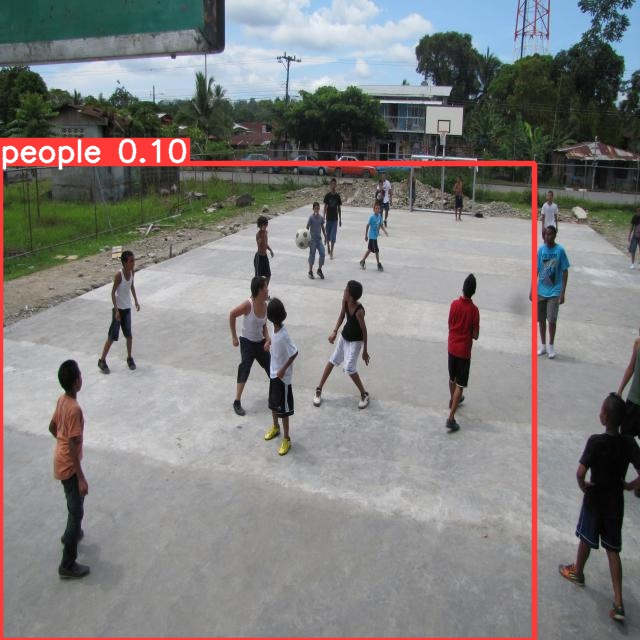

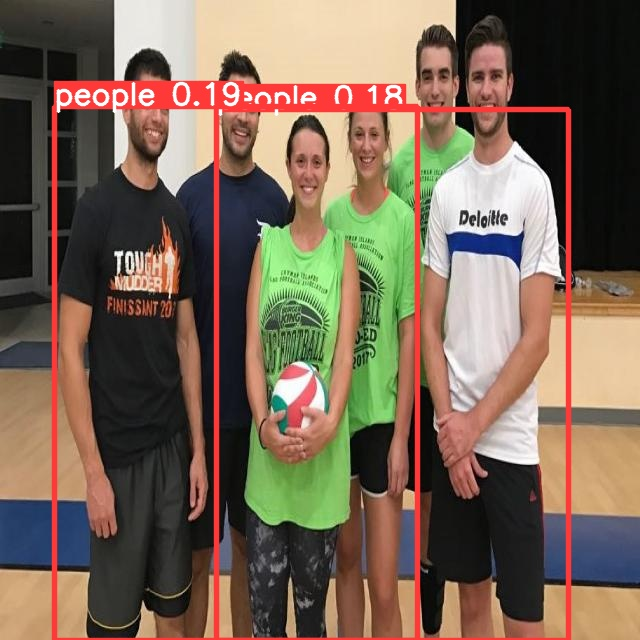

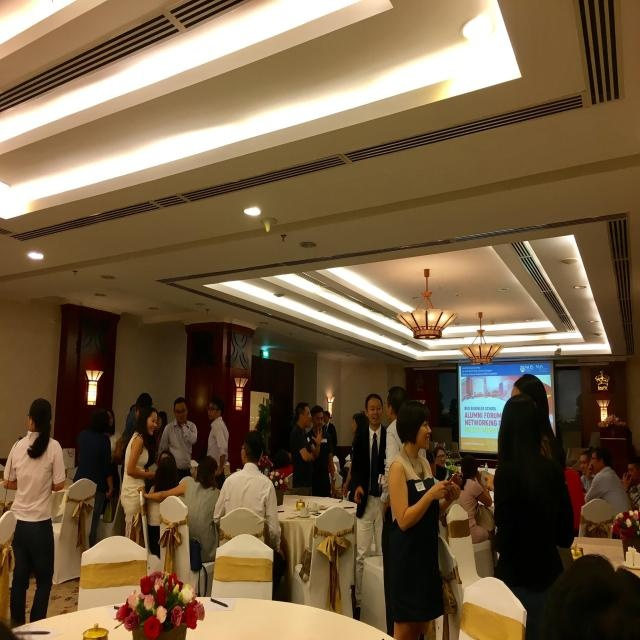

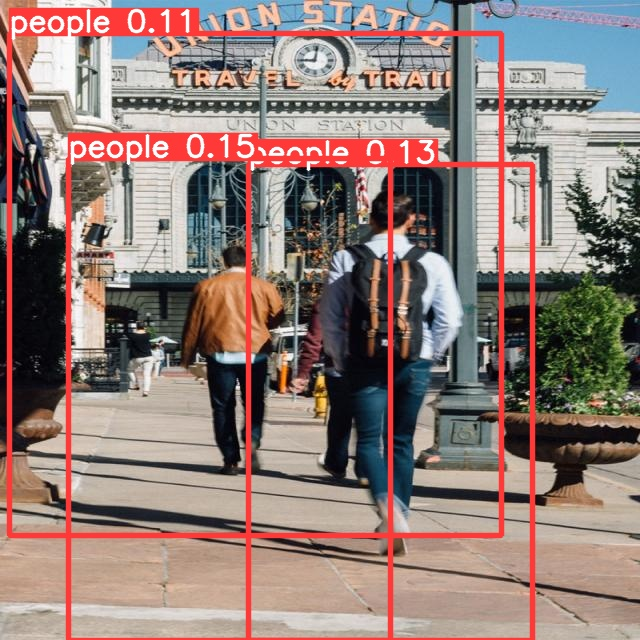

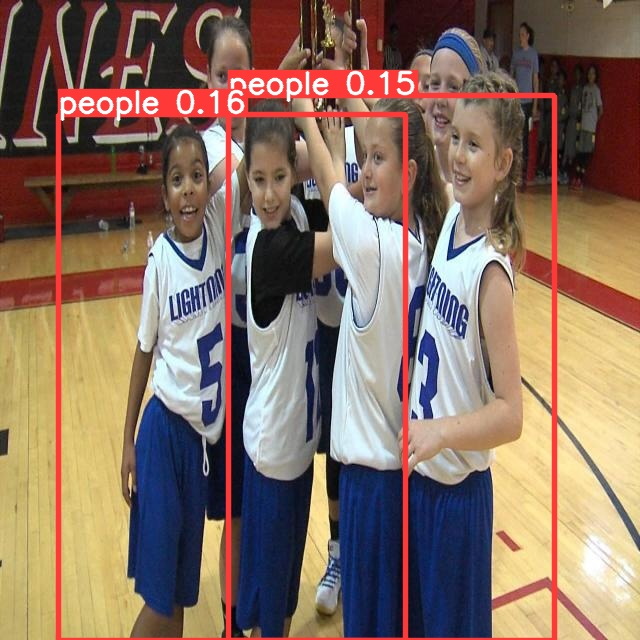

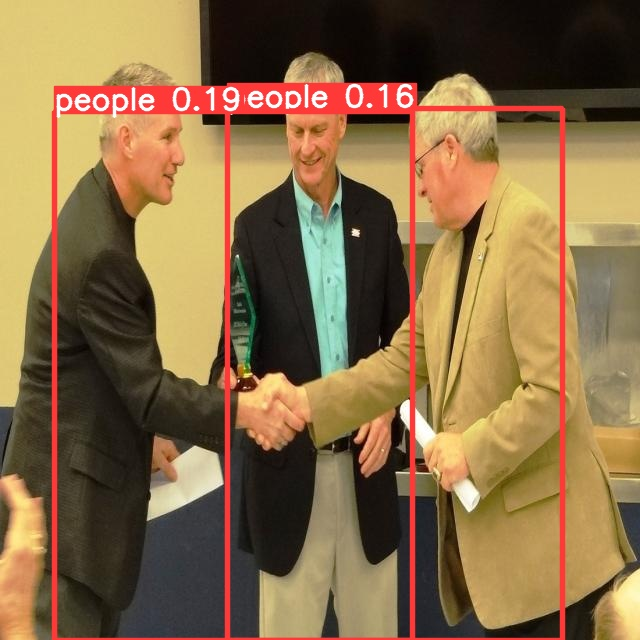

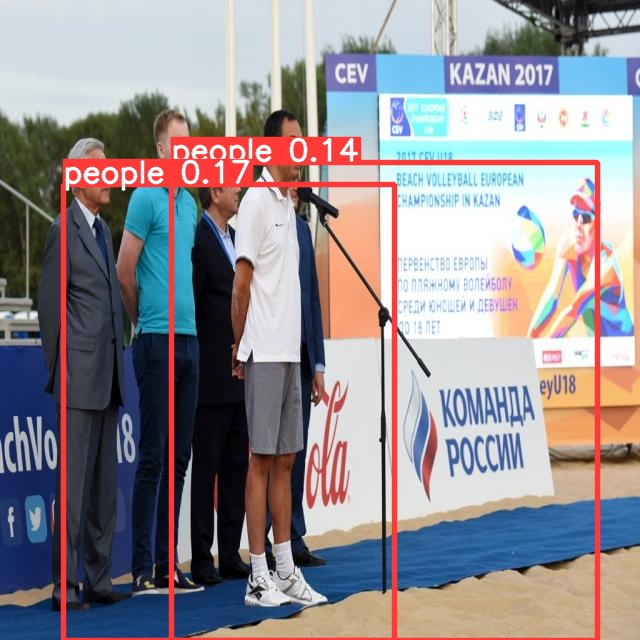

In [ ]:
import glob
from IPython.display import Image, display

for image in glob.glob('/content/yolov5/runs/detect/exp8/*.jpg')[:10]:
    display(Image(filename=image))
    print("\n")